In [62]:
import os
import h5py
import pandas as pd
import numpy as np
import seaborn as sns
from pycbc.detector import Detector
from pycbc.inference import io, models
import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# PyCBC inference model

In [63]:
def maxsnr(path):
    fp = io.loadfile(path,'r')
    cp = fp.read_config_file()
    data = fp.read_data()
    psds = fp.read_psds()
    model = models.read_from_config(cp, data=data, psds=psds)
    samples = fp.read_samples(list(fp['samples'].keys()))
    maxlidx = samples['loglikelihood'].argmax()
    maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}
    model.update(**maxlparams)
    #model.loglikelihood
    return (2*model.loglr)**0.5

In [64]:
maxsnr('./cpnest-shortstride/srate1024220/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf')

11.844297945444975

In [65]:
maxsnr('./cpnest-shortstride/srate1024220_221/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf')

13.257406521903457

# Plot waveform

In [66]:
#path = './cpnest-shortstride/srate1024220/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf'
path = './cpnest-shortstride/srate1024220_221/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf'
fp = io.loadfile(path,'r')
cp = fp.read_config_file()
data = fp.read_data()
psds = fp.read_psds()
    
# now let's load the model
model = models.read_from_config(cp, data=data, psds=psds)

# let's get the maximum likelihood point
samples = fp.read_samples(list(fp['samples'].keys()))
maxlidx = samples['loglikelihood'].argmax()
maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}

In [67]:
model.current_stats

{'logjacobian': nan,
 'logprior': nan,
 'loglikelihood': nan,
 'maxl_polarization': nan,
 'maxl_logl': nan}

In [68]:
# get the loglikelihood of these points
model.update(**maxlparams)
model.loglikelihood

-450372.4396654229

In [69]:
model.current_stats

{'logjacobian': nan,
 'logprior': nan,
 'loglikelihood': -450372.4396654229,
 'maxl_polarization': 3.629026949191813,
 'maxl_logl': -450369.27226975624}

In [70]:
# get the matched-filter SNR
print((2*model.loglr)**0.5)

13.257391831025492


In [71]:
gated_wfs = model.get_gated_waveforms()
gated_data = model.get_gated_data()

In [72]:
pol = model.current_stats['maxl_polarization']
data = {}
for detname in gated_wfs:
        det = Detector(detname)
        fp, fc = det.antenna_pattern(model.current_params['ra'],
                                     model.current_params['dec'],
                                     pol,
                                     model.current_params['tc'])
        hp, hc = gated_wfs[detname]
        h = fp*hp + fc*hc
        data[detname] = h

In [73]:
gated_wfs = model.whiten(data, 1)

In [74]:
# get the gated, whitened maxL waveform and plot it against
# the whitened data

# whiten them
#gated_wfs = model.whiten(gated_wfs, 1)
gated_data = model.whiten(gated_data, 1)
# convert to the time domain
gated_wfs = {ifo: d.to_timeseries() for ifo, d in gated_wfs.items()}
gated_data = {ifo: d.to_timeseries() for ifo, d in gated_data.items()}

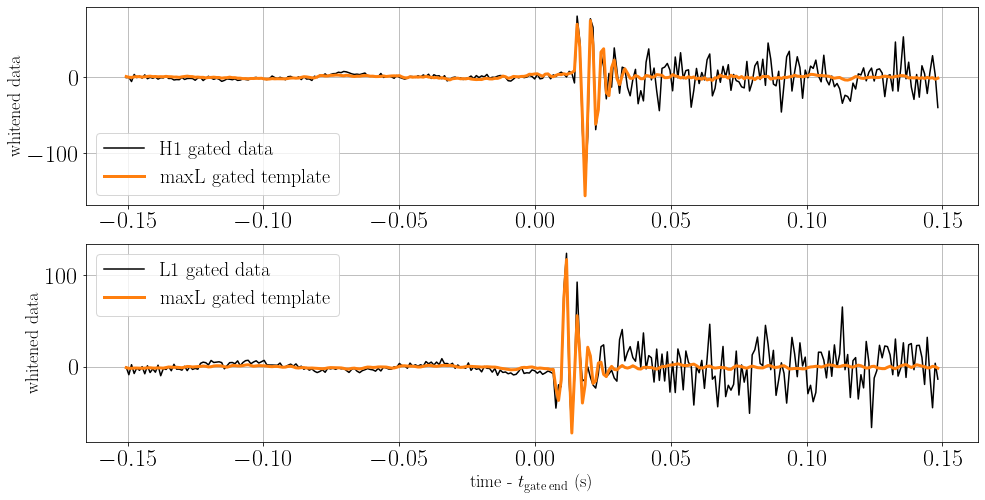

In [75]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))
for ii, ifo in enumerate(gated_wfs):
    ax = axes[ii]
    # we'll plot w.r.t. the geocentric end gate time
    t_gate_end = model.current_params['t_gate_end']
    d = gated_data[ifo].time_slice(t_gate_end-0.15, t_gate_end+0.15)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='black', label='{} gated data'.format(ifo))
    # plot the waveform
    d = gated_wfs[ifo].time_slice(t_gate_end-0.15, t_gate_end+0.15)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='C1', lw=3, label='maxL gated template')
    ax.legend()
    if ii == 1:
        ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)', fontsize=18)

    ax.set_ylabel('whitened data', fontsize=18)
fig.show()

# Zoom in

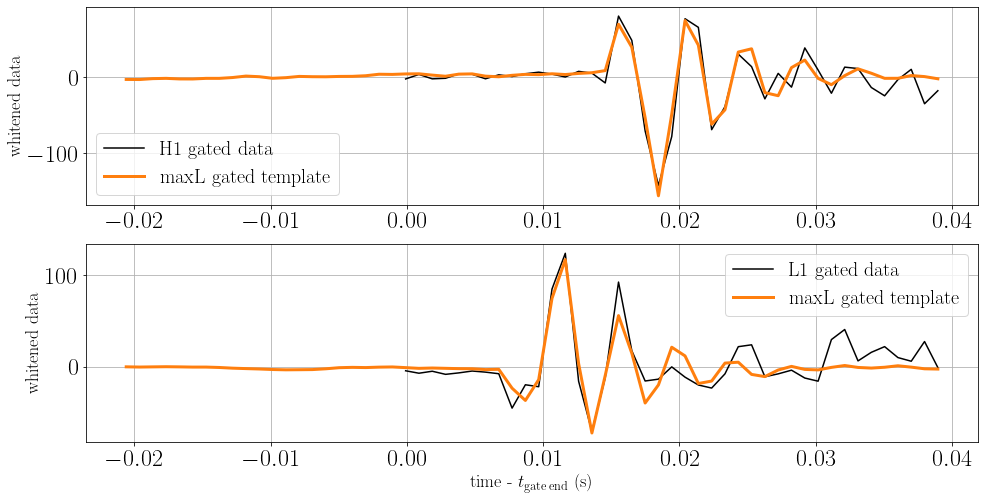

In [76]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))
for ii, ifo in enumerate(gated_wfs):
    ax = axes[ii]
    # we'll plot w.r.t. the geocentric end gate time
    t_gate_end = model.current_params['t_gate_end']
    d = gated_data[ifo].time_slice(t_gate_end-0., t_gate_end+0.04)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='black', label='{} gated data'.format(ifo))
    # plot the waveform
    d = gated_wfs[ifo].time_slice(t_gate_end-0.02, t_gate_end+0.04)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='C1', lw=3, label='maxL gated template')
    ax.legend()
    if ii == 1:
        ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)', fontsize=18)

    ax.set_ylabel('whitened data', fontsize=18)
fig.show()

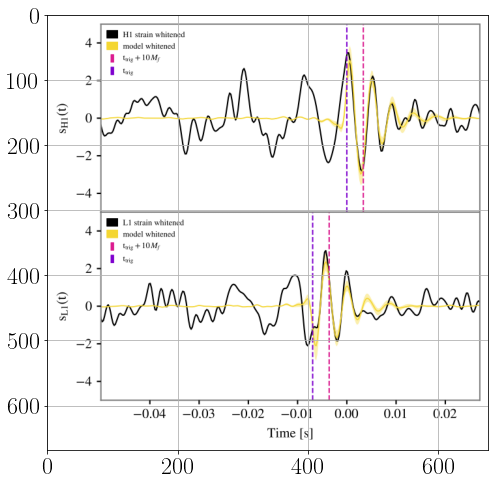

In [77]:
import matplotlib.image as mpimg
img = mpimg.imread('./pyring/reconstructed_waveform_whitened.png')

fig, ax = plt.subplots(figsize=(24, 8))
ax.imshow(img)

# Input the PyRing maxL parameters to PyCBC

In [78]:
pr221 = pd.read_csv('./pyring/t3-exp/221/GW150914_PROD1_Kerr_221_0M/Nested_sampler/posterior.dat',sep=' ')
pr221.columns = [pr221.columns[(i+1)%len(pr221.columns)] for i in range(len(pr221.columns))]
pr221 = pr221.drop(columns='#')

In [79]:
pr221

psi         Mf        af   cosiota      A2220      A2221  \
0      0.785343  89.345327  0.878494  0.110885  19.168956   7.212410   
1      0.513662  63.921465  0.300899 -0.860383  10.989152   9.834515   
2      2.356553  59.849367  0.238106  0.110025  32.902528  42.536300   
3      1.449374  62.917383  0.272787 -0.202846  11.260609  14.993182   
4      1.407390  56.249973  0.393234  0.285418  12.810371  12.556807   
...         ...        ...       ...       ...        ...        ...   
10346  2.056357  71.760062  0.703495 -0.375507  20.464938  27.639821   
10347  2.065350  73.650671  0.758807 -0.314995  24.161036  34.347457   
10348  0.170769  73.406196  0.745051 -0.539007  12.655558  17.563661   
10349  0.456365  69.902885  0.680534 -0.379966  21.562804  28.811392   
10350  0.397936  69.265033  0.667250 -0.421444  19.257521  28.988759   

        phi2220   phi2221          logL  logPrior  
0      5.626743  2.150944  38763.346674       0.0  
1      4.111884  1.493625  38763.504343       0.0  
2      2.455627  5.052970  38764.413612       0.0  
3      5.459088  1.237516  38764.773524       0.0  
4      4.650636  0.634935  38764.967650       0.0  
...         ...       ...           ...       ...  
10346  6.272882  2.603027  38779.252792       0.0  
10347  6.066029  2.407528  38779.262968       0.0  
10348  2.261225  4.845194  38779.276333       0.0  
10349  3.006484  5.683337  38779.340890       0.0  
10350  2.761109  5.404376  38779.455963       0.0  

[10351 rows x 10 columns]

In [80]:
maxlparams

{'final_mass': 77.24744487714477,
 'final_spin': 0.7933603506892939,
 'inclination': 1.6825838838701077,
 'logamp220': -19.7822043130713,
 'phi220': 3.7922217890395102,
 'amp221': 1.3510697733636268,
 'phi221': 0.22855808380252726}

In [81]:
len(pr221)

10351

In [82]:
i=len(pr221)-1

pyring_maxlparams={'final_mass':pr221['Mf'][i],
             'final_spin':pr221['af'][i],
             'inclination':np.arccos(pr221['cosiota'][i]),
             'logamp220':np.log10(pr221['A2220'][i]*1e-21),
             'phi220':pr221['phi2220'][i],
             'amp221':pr221['A2221'][i]/pr221['A2220'][i],
             'phi221':pr221['phi2221'][i]}

In [83]:
model.current_params

{'final_mass': 77.24744487714477,
 'final_spin': 0.7933603506892939,
 'inclination': 1.6825838838701077,
 'logamp220': -19.7822043130713,
 'phi220': 3.7922217890395102,
 'amp221': 1.3510697733636268,
 'phi221': 0.22855808380252726,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4077973,
 'ra': 2.242743237442093,
 'dec': -1.2242535126007028,
 'toffset': -0.0004833333333333334,
 'lmns': 222.0,
 't_gate_start': 1126259460.407314,
 't_gate_end': 1126259462.407314,
 'tc': 1126259462.4063141,
 'amp220': 1.6511848184999435e-20}

In [84]:
#model.static_params['ra'] = pyring_maxlparams['ra']
#model.static_params['dec'] = pyring_maxlparams['dec']
model.update(**pyring_maxlparams)
model.current_params

{'final_mass': 69.26503265694951,
 'final_spin': 0.6672497381036405,
 'inclination': 2.0058330150268753,
 'logamp220': -19.71539962133419,
 'phi220': 2.761109457095157,
 'amp221': 1.5053214407158264,
 'phi221': 5.404376118439777,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4077973,
 'ra': 2.242743237442093,
 'dec': -1.2242535126007028,
 'toffset': -0.0004833333333333334,
 'lmns': 222.0}

In [85]:
model.loglikelihood

-450398.16329125577

In [86]:
model.lognl

-450460.31886607566

In [87]:
model.current_stats

{'logjacobian': nan,
 'logprior': nan,
 'loglikelihood': -450398.16329125577,
 'maxl_polarization': 2.918316298830158,
 'maxl_logl': -450394.27514467656}

In [88]:
model.loglr

62.15557481988799

In [89]:
(2*model.loglr)**0.5

11.149491003618774

# Only get SNR ~ 5?